<a href="https://colab.research.google.com/github/sheikmohdimran/Experiments_2020/blob/master/NLP/LM_exp_template_wandb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
if 'google.colab' in sys.modules:
  !pip install -Uqq fastai einops datasets

     |████████████████████████████████| 194kB 14.5MB/s 
     |████████████████████████████████| 163kB 28.1MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 245kB 25.2MB/s 
     |████████████████████████████████| 17.7MB 344kB/s 


Note: Restart the runtime after installing fastai

In [ ]:
!pip install -Uqq wandb yappi gprof2dot pyinstrument

     |████████████████████████████████| 1.8MB 14.8MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 102kB 12.0MB/s 
     |████████████████████████████████| 133kB 44.6MB/s 
     |████████████████████████████████| 163kB 48.9MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 


## Download the tranformer and tokenizer code

In [ ]:
!wget -q https://raw.githubusercontent.com/morganmcg1/reformer-fastai/main/basic_tokenizers.py
!wget -q https://raw.githubusercontent.com/morganmcg1/reformer-fastai/main/basic_transformer.py

## Download and Unpack enwik8 Data

Download and unzip enwik8 data


In [ ]:
!wget -P data/ http://mattmahoney.net/dc/enwik8.zip
!unzip data/enwik8.zip -d data/
!ls data
!head -n 132 data/enwik8

--2020-11-22 15:15:19--  http://mattmahoney.net/dc/enwik8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.24
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36445475 (35M) [application/zip]
Saving to: ‘data/enwik8.zip’

enwik8.zip          100%[===================>]  34.76M   717KB/s    in 50s     

2020-11-22 15:16:10 (706 KB/s) - ‘data/enwik8.zip’ saved [36445475/36445475]

Archive:  data/enwik8.zip
  inflating: data/enwik8             
enwik8	enwik8.zip
<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd" version="0.3" xml:lang="en">
  <siteinfo>
    <sitename>Wikipedia</sitename>
    <base>http://en.wikipedia.org/wiki/Main_Page</base>
    <generator>MediaWiki 1.6alpha</generator>
    <case>first-letter</case>
      <na

## Actual start of the experiment

In [ ]:
import sys
import six
from fastai.text.all import *

In [ ]:
from basic_tokenizers import ByteTextTokenizer
from basic_transformer import TransformerLM

## Experiment Tracking

Make sure you have wandb and are logged in:

In [ ]:
!wandb login <your_identifier>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Load Experiment Tracking with Weights & Biases:

## Wandb experiment logging
Suggeted [wandb.init logging](https://docs.wandb.com/library/init) to help keep track of experiments:

**WANDB_NAME**

A specific name for a particular experiment, e.g. "lsh_2_hash_enwik8"

**GROUP**

Group identifiers will help organise and **group experiments together** in the wandb interface. Suggested identifier to use are:

- "TEST" : for general testing
- "SHARED-QK" : for Shared Query-Key experiments
- "LSH" : LSH-related experiemnts
- "REVERSIBLE" : reversible layers experiments
- "WMT" : for the WMT task

**NOTES**

A longer description of the run, like a -m commit message in git. This helps you remember what you were doing when you ran this run.

**CONFIG**

A dictionary-like object for saving inputs to your job, like hyperparameters for a model or settings for a data preprocessing job. The config will show up in a table in the UI that you can use to group, filter, and sort runs. Keys should not have . in the names, and values should be under 10 MB.

**TAGS**

A list of strings, which will populate the list of tags on this run in the UI. Tags are useful for organizing runs together, or applying temporary labels like "baseline" or "production". It's easy to add and remove tags in the UI, or filter down to just runs with a specific tag.

In [ ]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'enc_lm_enwik8'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Testing the encoder LM model works'
CONFIG = {}
TAGS =['enc_lm','test']

Initialise wandb logging, pleaes **do not change** `project` or `entity` (that that everything gets logged to the same place)

In [ ]:
def read_lines(path):
    """Tokenizes a text file."""
    assert os.path.exists(path)
    lines=[]
    with open(path, 'r') as f:
        tokens = 0
        for line in f:
            lines.append(line)  # + ['<eos>'])            
    return lines

## Load the file into the dataframe

In [ ]:
enwik8 = read_lines('data/enwik8')
df = pd.DataFrame({'text':enwik8})
print(len(df))
df.head()

1128024


,text
0,"<mediawiki xmlns=""http://www.mediawiki.org/xml/export-0.3/"" xmlns:xsi=""http://www.w3.org/2001/XMLSchema-instance"" xsi:schemaLocation=""http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd"" version=""0.3"" xml:lang=""en"">\n"
1,<siteinfo>\n
2,<sitename>Wikipedia</sitename>\n
3,<base>http://en.wikipedia.org/wiki/Main_Page</base>\n
4,<generator>MediaWiki 1.6alpha</generator>\n


# Prepare Data

Load tokenizer

In [ ]:
bte = ByteTextTokenizer(is_lm=True, add_bos=True, add_eos=True)

In [ ]:
# # Patch the LMDataloader
# @patch
# def create_item(self:LMDataLoader, seq):
#     if seq>=self.n: raise IndexError
#     sl = self.last_len if seq//self.bs==self.n_batches-1 else self.seq_len
#     st = (seq%self.bs)*self.bl + (seq//self.bs)*self.seq_len
#     txt = self.chunks[st : st+sl+1]    
#     return LMTensorText(txt[:-1]),txt[1:]
#     # return LMTensorText(txt[:-1].tolist()+[1]), LMTensorText(txt[1:].tolist()+[1])   ## ADD EOS TOKEN

Calc splits

In [ ]:
# Back up the original dataframe
df_bckp=df

In [ ]:
# Take 4000 records for sake of performance
df=df_bckp[:4000]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4000 non-null   object
dtypes: object(1)
memory usage: 31.4+ KB


In [ ]:
# Split enwik8 by character count
a=df.apply(lambda x: x.str.len())
a.columns=['lens']
df=pd.concat([df,a], axis=1)
df['lens_cum_sum'] = df.lens.cumsum()

In [ ]:
df.lens.sum()

347377

In [ ]:
train_cutoff = int(df.lens.sum()*0.5) #- 10000000  # keep all but 10M characters for val and test
    
train_idxs = df.loc[df['lens_cum_sum'] < train_cutoff].index.values
train_idxs = list(range(0, max(train_idxs)))

remaining_idxs = len(df) - max(train_idxs)
validation_idxs = list(range(max(train_idxs), max(train_idxs) + int(remaining_idxs/2)))
test_idxs = list(range(max(validation_idxs), len(df)))

splits = [train_idxs, validation_idxs]

In [ ]:
len(train_idxs),len(validation_idxs)

(2253, 874)

Get dls

In [ ]:
# Quick naive split alternative
# cut = int(len(df)*0.8)
# splits = range_of(df)[:cut], range_of(df[cut:])

tfms = [attrgetter("text"), bte]
dsets = Datasets(df, [tfms, tfms], splits=splits, dl_type=LMDataLoader)

vocab_sz = bte.vocab_size
bs,sl = 32,128
pad_seq2seq = partial(pad_input, pad_idx=bte.pad_token_id, pad_fields=[0,1])

In [ ]:
## Yappi - Profiler 1
#import yappi
#yappi.start()

In [ ]:
# Profiler 2
#from pyinstrument import Profiler

#profiler = Profiler()
#profiler.start()

In [ ]:
dls = dsets.dataloaders(bs=bs, seq_len=sl, before_batch=pad_seq2seq)

In [ ]:
# Profiler 2
#profiler.stop()

In [ ]:
# Profiler 2
#print(profiler.output_text(unicode=True, color=True))

In [ ]:
## Yappi - Profiler 1
#func_stats = yappi.get_func_stats()
#func_stats.save('callgrind.out', 'CALLGRIND')
#yappi.stop()
#yappi.clear_stats()

In [ ]:
## Yappi - Profiler 1
#!gprof2dot -f callgrind -n10 -s callgrind.out > valgrind.dot
#!dot -Tpng valgrind.dot -o valgrind.png

In [ ]:
dls.show_batch(max_n=2)

,text,text_
0,"<bos>===Historical events===\n<eos><bos>:* [[Causes of autism]]\n<eos><bos> </page>\n<eos><bos> <revision>\n<eos><bos>In all, Abu Dhabi issued 95 stamps from 1964 t","===Historical events===\n<eos><bos>:* [[Causes of autism]]\n<eos><bos> </page>\n<eos><bos> <revision>\n<eos><bos>In all, Abu Dhabi issued 95 stamps from 1964 to"
1,"rred method of terrorism, dynamite, earned him the moniker &quot;Dynamost.&quot; \n<eos><bos>The ''Platform'' continues to inspire some","red method of terrorism, dynamite, earned him the moniker &quot;Dynamost.&quot; \n<eos><bos>The ''Platform'' continues to inspire some c"


In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

((32, 128), (32, 128))

In [ ]:
vocab_sz = bte.vocab_size

# Begin Experiment Training

In [ ]:
from fastai.callback.wandb import *

In [ ]:
wandb.login()

wandb: Currently logged in as: sheikmohdimran (use `wandb login --relogin` to force relogin)


True

In [ ]:
wandb.init(reinit=True, project="reformer-fastai", name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS)

epoch,4
train_loss,5.21875
raw_loss,5.17499
wd_0,0.05
sqr_mom_0,0.99
lr_0,0.00085
mom_0,0.86464
eps_0,1e-05
_step,31
_runtime,118
_timestamp,1606064747


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
train_loss,▅▅▄▄▅▆▇▇██████▇▆▆▆▆▆▅▅▅▁▁▁▁▁▂▂▂
raw_loss,▄▃▃▃████▆▆▆▅▇▆▅▅▅▅▅▄▃▃▂▁▁▁▁▃▃▃▂
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▃▄▄▄▄▄▂▃▄▄▄▄▄▁▂▃▄▄▄▄▄▁▂▅▇███▇
mom_0,█▇▄▂▁▁▁▂▇▄▂▁▁▁▂█▇▄▂▁▁▁▂█▇▄▂▁▁▁▂
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▇▇▇▇▇▇▇▇████████
_timestamp,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▇▇▇▇▇▇▇▇████████


In [ ]:
learn = Learner(dls, TransformerLM(vocab_sz, 512),
                loss_func=CrossEntropyLossFlat(),# cbs=[WandbCallback(log_model=False)],
                metrics=[accuracy, Perplexity()])#.to_native_fp16()

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.04786301031708717)

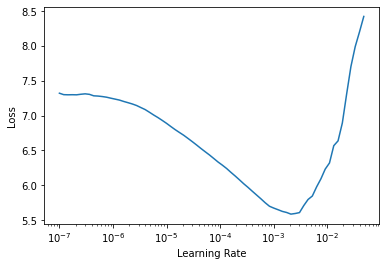

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(2, 5e-4, wd=0.05,cbs=WandbCallback(log_model=False))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.358492,3.331251,0.198089,27.973318,00:10
1,3.409476,3.066231,0.223202,21.460865,00:09


WandbCallback was not able to get prediction samples -> wandb.log must be passed a dictionary
